# 1. AutoEncoder

## 1. Define the Autoencoder model

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Plan-to-Do: Encoder part
        # Encoder: 64x64->32->16->8 (channels 3->64->128->256)
        self.encoder = nn.Sequential(
          nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1), #64->32
          nn.ReLU(inplace=True),
          nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), #32->16
          nn.BatchNorm2d(128),
          nn.ReLU(inplace=True),
          nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), #16->8
          nn.BatchNorm2d(256),
          nn.ReLU(inplace=True),
        )
        # Plan-to-Do: Decoder part
        # Decoder: 8->16->32->64 (channels 256->128->64->3)
        self.decoder = nn.Sequential(
          nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), #8->16
          nn.BatchNorm2d(128),
          nn.ReLU(inplace=True),
          nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), #16->32
          nn.BatchNorm2d(64),
          nn.ReLU(inplace=True),
          nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1), #32->64
          nn.Sigmoid(), # keep outputs in [0,1] to match MSE on normalized inputs
        )


    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# 1.2. Load Dataset

In [2]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),        # [0,1]
])
# Download and load the Oxford-IIIT Pets dataset
dataset = datasets.OxfordIIITPet(root='./data', split='trainval', download=True, transform=transform)

# Select images for the "British Shorthair" class, label 7 represents "British Shorthair"
british_shorthair_class = 7
cat_indices = [i for i, label in enumerate(dataset._labels) if label == british_shorthair_class]

# Create a subset of the dataset with only "British Shorthair"
cat_dataset = Subset(dataset, cat_indices)

# Load the dataset
dataloader = DataLoader(cat_dataset, batch_size=32, shuffle=True)

# 1.3. Define the model, loss function, and optimizer

In [3]:
# Define the model, loss function, and optimizer
model = Autoencoder().cuda()  # Use GPU for training
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.002, weight_decay=1e-5) # Added weight_decay

# Add a learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

# 1.4. Model Training

In [4]:
# Train the model
num_epochs = 200
for epoch in range(num_epochs):
    running_loss = 0.0
    for data in dataloader:
        inputs, _ = data
        inputs = inputs.cuda()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, inputs)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}')

    # Step the scheduler
    scheduler.step(epoch_loss)

Epoch [1/200], Loss: 0.003521
Epoch [2/200], Loss: 0.001643
Epoch [3/200], Loss: 0.001137
Epoch [4/200], Loss: 0.000931
Epoch [5/200], Loss: 0.000832
Epoch [6/200], Loss: 0.000768
Epoch [7/200], Loss: 0.000721
Epoch [8/200], Loss: 0.000688
Epoch [9/200], Loss: 0.000650
Epoch [10/200], Loss: 0.000620
Epoch [11/200], Loss: 0.000594
Epoch [12/200], Loss: 0.000583
Epoch [13/200], Loss: 0.000563
Epoch [14/200], Loss: 0.000531
Epoch [15/200], Loss: 0.000557
Epoch [16/200], Loss: 0.000494
Epoch [17/200], Loss: 0.000494
Epoch [18/200], Loss: 0.000460
Epoch [19/200], Loss: 0.000445
Epoch [20/200], Loss: 0.000413
Epoch [21/200], Loss: 0.000388
Epoch [22/200], Loss: 0.000370
Epoch [23/200], Loss: 0.000329
Epoch [24/200], Loss: 0.000316
Epoch [25/200], Loss: 0.000306
Epoch [26/200], Loss: 0.000304
Epoch [27/200], Loss: 0.000292
Epoch [28/200], Loss: 0.000266
Epoch [29/200], Loss: 0.000251
Epoch [30/200], Loss: 0.000255
Epoch [31/200], Loss: 0.000244
Epoch [32/200], Loss: 0.000265
Epoch [33/200], L

# 1.5. Inference

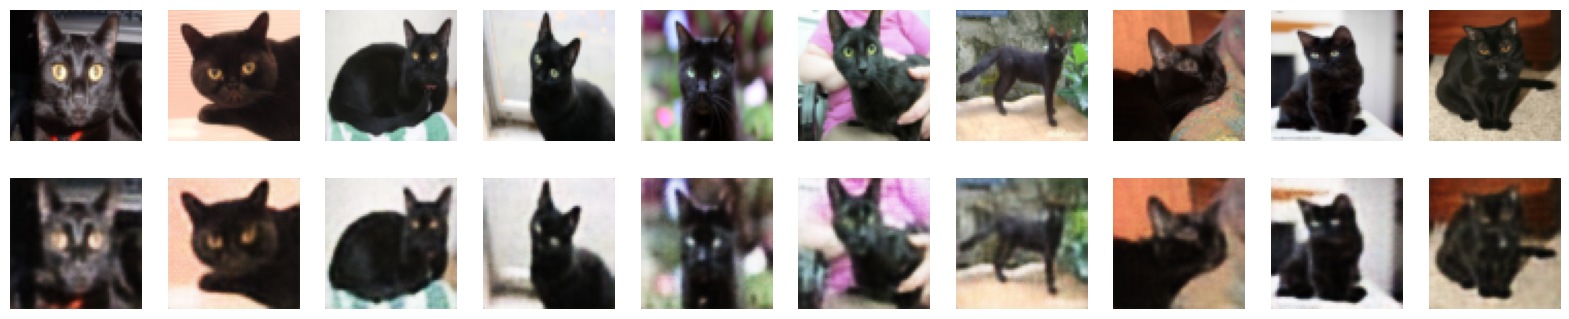

In [5]:
# Test the model and reconstruct 10 images of British Shorthair cats
model.eval()
with torch.no_grad():
    sample_loader = DataLoader(cat_dataset, batch_size=10, shuffle=True)
    inputs, _ = next(iter(sample_loader))
    inputs = inputs.cuda()
    outputs = model(inputs)

    # Move results to CPU and display the images
    inputs = inputs.cpu()
    outputs = outputs.cpu()

    fig, axes = plt.subplots(2, 10, figsize=(20, 4))
    for i in range(10):
        # Original image
        axes[0, i].imshow(inputs[i].permute(1, 2, 0))
        axes[0, i].axis('off')
        # Reconstructed image
        axes[1, i].imshow(outputs[i].permute(1, 2, 0))
        axes[1, i].axis('off')
    plt.show()

# 2. VAE

## 2.1. Define VAE Model

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Define the Variational Autoencoder (VAE) model
class VAE(nn.Module):
    def __init__(self, latent_dim: int = 128):
        super(VAE, self).__init__()
        # Plan-to-Do: Encoder part
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
          nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1), # 64->32
          nn.ReLU(inplace=True),
          nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # 32->16
          nn.BatchNorm2d(128),
          nn.ReLU(inplace=True),
          nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # 16->8
          nn.BatchNorm2d(256),
          nn.ReLU(inplace=True),
          nn.Flatten(),
        )
        self.enc_out_dim = 256 * 8 * 8
        self.fc_mu = nn.Linear(self.enc_out_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.enc_out_dim, latent_dim)

        # Plan-to-Do: Decoder part
        self.decoder_input = nn.Linear(latent_dim, self.enc_out_dim)
        self.decoder = nn.Sequential(
          nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # 8->16
          nn.BatchNorm2d(128),
          nn.ReLU(inplace=True),
          nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), # 16->32
          nn.BatchNorm2d(64),
          nn.ReLU(inplace=True),
          nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1), # 32->64
          nn.Sigmoid(),
        )

    def encode(self, x):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = self.decoder_input(z)
        z = z.view(-1, 256, 8, 8)
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function for VAE (Reconstruction Loss + KL Divergence)
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_divergence

## 2.2 Data Preprocess

In [7]:
# Define transformations and load the Oxford-IIIT Pets dataset
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Load the dataset (British Shorthair subset)
dataset = datasets.OxfordIIITPet(root='./data', split='trainval', download=True, transform=transform)
british_shorthair_class = 7
cat_indices = [i for i, label in enumerate(dataset._labels) if label == british_shorthair_class]
cat_dataset = Subset(dataset, cat_indices)
dataloader = DataLoader(cat_dataset, batch_size=32, shuffle=True)

## 2.3 Model Training

In [8]:
# Initialize VAE model, optimizer, and loss function
vae_model = VAE().cuda()
optimizer = optim.Adam(vae_model.parameters(), lr=0.002, weight_decay=1e-5) # Added weight_decay

# Add a learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

# Train the VAE model
num_epochs = 200
for epoch in range(num_epochs):
    vae_model.train()
    running_loss = 0
    for data in dataloader:
        inputs, _ = data
        inputs = inputs.cuda()

        # Forward pass
        recon_images, mu, logvar = vae_model(inputs)
        loss = vae_loss(recon_images, inputs, mu, logvar)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}')

    # Step the scheduler
    scheduler.step(epoch_loss)

Epoch [1/200], Loss: 155959031.155518
Epoch [2/200], Loss: 6432.332357
Epoch [3/200], Loss: 3292.062581
Epoch [4/200], Loss: 3241.281657
Epoch [5/200], Loss: 3471.352865
Epoch [6/200], Loss: 3444.947835
Epoch [7/200], Loss: 3498.375651
Epoch [8/200], Loss: 3383.173828
Epoch [9/200], Loss: 3305.619548
Epoch [10/200], Loss: 3198.308675
Epoch [11/200], Loss: 3142.503499
Epoch [12/200], Loss: 3171.652425
Epoch [13/200], Loss: 3000.444499
Epoch [14/200], Loss: 2973.685872
Epoch [15/200], Loss: 2926.378174
Epoch [16/200], Loss: 2898.846191
Epoch [17/200], Loss: 2841.851562
Epoch [18/200], Loss: 2791.739909
Epoch [19/200], Loss: 2985.021159
Epoch [20/200], Loss: 2644.019124
Epoch [21/200], Loss: 2625.920654
Epoch [22/200], Loss: 2606.004964
Epoch [23/200], Loss: 2555.396159
Epoch [24/200], Loss: 2514.220052
Epoch [25/200], Loss: 2405.686930
Epoch [26/200], Loss: 2327.411458
Epoch [27/200], Loss: 2403.990153
Epoch [28/200], Loss: 2380.191895
Epoch [29/200], Loss: 2249.789714
Epoch [30/200], Lo

## 2.4 Inference

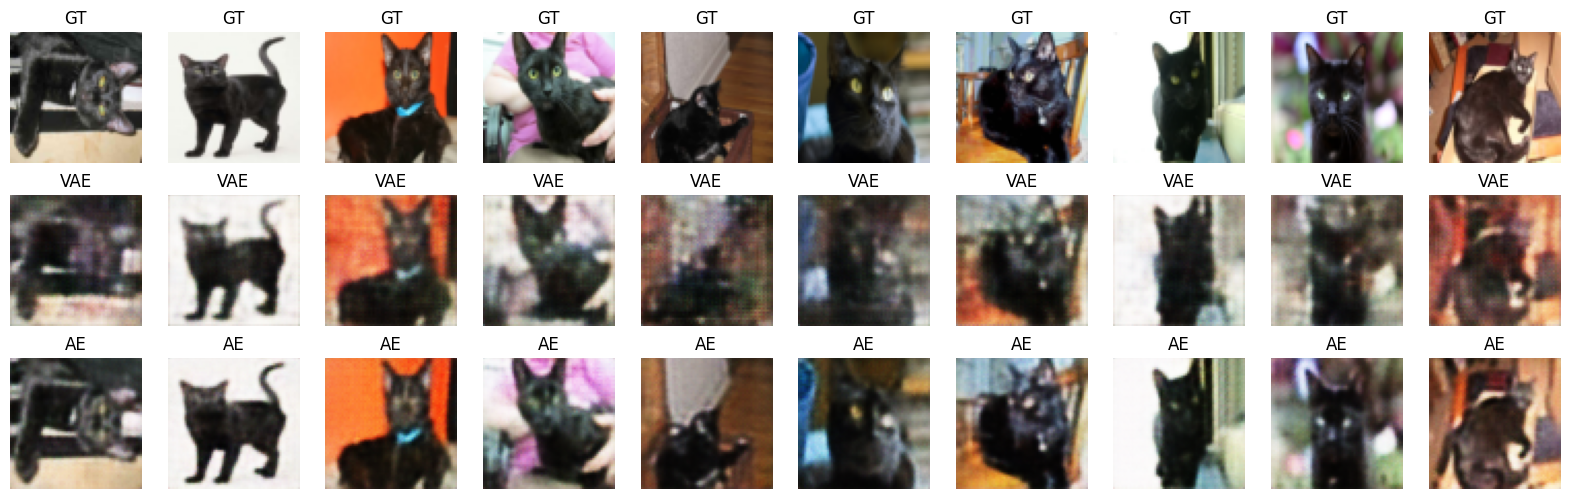

In [9]:
# Generate 10 images using the trained VAE model
vae_model.eval()
model.eval()
with torch.no_grad():
    # Load 10 sample images
    sample_loader = DataLoader(cat_dataset, batch_size=10, shuffle=True)
    inputs, _ = next(iter(sample_loader))
    inputs = inputs.cuda()

    # Get reconstructions from both VAE and AE
    vae_recon_images, _, _ = vae_model(inputs)
    ae_recon_images = model(inputs)

    # Move results to CPU for visualization
    inputs = inputs.cpu()
    vae_recon_images = vae_recon_images.cpu()
    ae_recon_images = ae_recon_images.cpu()

    # Display original (GT), VAE reconstructed, and AE reconstructed images
    fig, axes = plt.subplots(3, 10, figsize=(20, 6))
    for i in range(10):
        # Original image (Ground Truth)
        axes[0, i].imshow(inputs[i].permute(1, 2, 0))
        axes[0, i].set_title("GT")
        axes[0, i].axis('off')

        # VAE reconstructed image
        axes[1, i].imshow(vae_recon_images[i].permute(1, 2, 0))
        axes[1, i].set_title("VAE")
        axes[1, i].axis('off')

        # AE reconstructed image
        axes[2, i].imshow(ae_recon_images[i].permute(1, 2, 0))
        axes[2, i].set_title("AE")
        axes[2, i].axis('off')

    plt.show()

## 2.5 Test Result

In [13]:
# pip install torchmetrics lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.1 MB/s eta 0:00:00


In [14]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from torchmetrics.functional import peak_signal_noise_ratio, structural_similarity_index_measure
import lpips
import pandas as pd
import matplotlib.pyplot as plt

# Load the LPIPS model for perceptual similarity evaluation
lpips_fn = lpips.LPIPS(net='alex').cuda()

# Function to calculate PSNR, SSIM, and LPIPS for a batch of images
def calculate_metrics(originals, reconstructions):
    # Calculate PSNR
    psnr = peak_signal_noise_ratio(reconstructions, originals, data_range=1.0)

    # Calculate SSIM
    ssim = structural_similarity_index_measure(reconstructions, originals, data_range=1.0)

    # Calculate LPIPS (convert to [-1, 1] range as LPIPS expects this range)
    originals_lpips = (originals * 2 - 1).cuda()
    reconstructions_lpips = (reconstructions * 2 - 1).cuda()
    lpips_value = lpips_fn(originals_lpips, reconstructions_lpips).mean().item()

    return psnr.item(), ssim.item(), lpips_value

# Initialize lists to store results for both models
ae_results = {'PSNR': [], 'SSIM': [], 'LPIPS': []}
vae_results = {'PSNR': [], 'SSIM': [], 'LPIPS': []}

# Load 100 images for evaluation
sample_loader = DataLoader(cat_dataset, batch_size=10, shuffle=True)

# Evaluate AE and VAE models on 100 images
vae_model.eval()
model.eval()

with torch.no_grad():
    count = 0
    for inputs, _ in sample_loader:
        inputs = inputs.cuda()

        # Get reconstructions from both AE and VAE models
        ae_recon_images = model(inputs)
        vae_recon_images, _, _ = vae_model(inputs)

        # Move images to CPU for metric calculations
        inputs_cpu = inputs.cpu()
        ae_recon_cpu = ae_recon_images.cpu()
        vae_recon_cpu = vae_recon_images.cpu()

        # Calculate metrics for AE
        psnr_ae, ssim_ae, lpips_ae = calculate_metrics(inputs_cpu, ae_recon_cpu)
        ae_results['PSNR'].append(psnr_ae)
        ae_results['SSIM'].append(ssim_ae)
        ae_results['LPIPS'].append(lpips_ae)

        # Calculate metrics for VAE
        psnr_vae, ssim_vae, lpips_vae = calculate_metrics(inputs_cpu, vae_recon_cpu)
        vae_results['PSNR'].append(psnr_vae)
        vae_results['SSIM'].append(ssim_vae)
        vae_results['LPIPS'].append(lpips_vae)

        count += len(inputs)
        if count >= 100:
            break

# Convert results to DataFrames for tabular display
ae_df = pd.DataFrame(ae_results).mean()
vae_df = pd.DataFrame(vae_results).mean()

# Create a comparison table
comparison_df = pd.DataFrame({
    'Metric': ['PSNR', 'SSIM', 'LPIPS'],
    'AE': [ae_df['PSNR'], ae_df['SSIM'], ae_df['LPIPS']],
    'VAE': [vae_df['PSNR'], vae_df['SSIM'], vae_df['LPIPS']]
})

# Display the comparison table using print()
print(comparison_df)

# Alternatively, you can save the DataFrame to a CSV file
comparison_df.to_csv("AE_vs_VAE_performance_comparison.csv", index=False)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 173MB/s]


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth


/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `peak_signal_noise_ratio` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `peak_signal_noise_ratio` from `torchmetrics.image` instead.
  _future_warning(
/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


  Metric         AE        VAE
0   PSNR  28.928677  20.345943
1   SSIM   0.879250   0.593063
2  LPIPS   0.092461   0.275351
